<div class="title"> Predict The Stock Market With Machine Learning</div>

In [ ]:
from IPython.core.display import HTML

HTML("""<style>

.title{
  font-size:40px;
  font-weight:bold;
  font-family:arial;
  padding-top:15px;
  padding-bottom:15px;
}

.p{
  font-size:15px;
  font-weight:bold;
  line-height: 180%;
}


</style>""")

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white")
sns.set_context("notebook")
## sns.set_theme()

import yfinance as yf

<h1>Introduction</h1>

Dataset為標普500的股價歷史記錄，每列為不包含六、日及股巿休巿日的每日股價歷記錄，包含"Date"index以及以下欄位：

- Open
- High
- Low
- Close
- Volume

我們想利用這些欄位來預測股價隔日的漲跌。

Source: [Predict The Stock Market With Machine Learning Project Tutorial](https://www.youtube.com/watch?v=1O_BenficgE&ab_channel=Dataquest)

<h1>Import Dataset</h1>

In [ ]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
display(sp500.head(2))
sp500.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,0,0
1950-01-04,16.85,16.85,16.85,16.85,1890000,0,0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-08-29,4034.580078,4062.98999,4017.419922,4030.610107,2963020000,0,0
2022-08-30,4041.250000,4044.97998,3965.209961,3986.159912,2080875000,0,0


In [ ]:
type(sp500.index)  ## 可看到index為datatime obj

pandas.core.indexes.datetimes.DatetimeIndex

<h1>Cleaning and Visualizing Data</h1>

<AxesSubplot:xlabel='Date'>

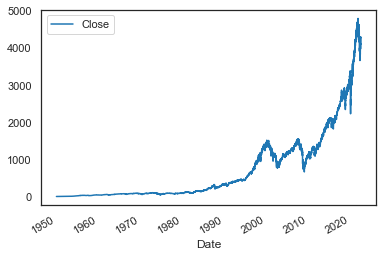

In [ ]:
sp500.plot.line(y="Close", use_index=True)

In [ ]:
## 移除不需要的欄位
sp500 = sp500.drop(["Dividends", "Stock Splits"], axis=1)

<h2>Setting our target</h2>

<div class="p">
    
    我們的目標是預測未來一日的漲跌，而非股價。因為相比於精準的預測股價，我們更在意的是股價波動的方向，依此來做為買賣依據。如果target為精準的預測股價，你可能可較精準的預測數字，但損失了對方向預測的準確度。
    因此我們想預測的是在股價上漲的日子，我們可否正確的預測了它們的上漲，進而可依此做為買賣依據。
    - Target:股價是上漲或下跌
</div>


In [ ]:
## 新增tomorrow欄
sp500["tomorrow"] = sp500["Close"].shift(-1)  ## 後一天的價格，-1表整欄相對於index往上挪一列

## 新增Target欄
sp500["Target"] = (sp500["tomorrow"] > sp500["Close"]).astype(int)

## 移除1990前的data
sp500 = sp500.loc[ "1990-01-01": ].copy()
sp500.head()

,Open,High,Low,Close,Volume,tomorrow,Target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


<h1> Base Model Training</h1>

RandomForest優點:
1. 因為其以randomised parameter去train一堆樹，取其平均，故相對不容易overfit
2. run relatively quickly
3. 可pick up數據集中的non-linear tendency。ex:open price與target不具linear relationship

- 設置random_state是為了確保model的改善是因為你做的某些改變，而非因randomness。
- time series data不能使用cv，因為cv無法將time series data的特性take into account，cv會造成你用future data來predict past，但real world中這是不可能的，這形成了data leakage，即leak了某些info給model，這使你可train極佳的accuracy，但在real world表現很差。
- 因此，train set取最新100列以前的列
- precision score很重要:因為我們希望當我們預測上漲的時候，它真的上漲

In [ ]:
## Train a initial model
from sklearn.ensemble import RandomForestClassifier 
print(sp500.shape)

(8230, 7)


In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
## measure model accuracy
from sklearn.metrics import classification_report, precision_score

## predict回傳的是numpy array，因此轉為series較易處理
preds = pd.Series(model.predict(test[predictors]), index=test.index)  
preds

print(precision_score(test["Target"], preds))
print(classification_report(test["Target"], preds))

0.48717948717948717
              precision    recall  f1-score   support

           0       0.73      0.29      0.41        56
           1       0.49      0.86      0.62        44

    accuracy                           0.54       100
   macro avg       0.61      0.57      0.52       100
weighted avg       0.62      0.54      0.50       100



<AxesSubplot:xlabel='Date'>

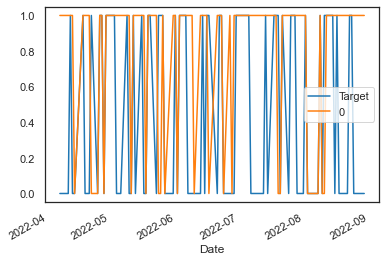

In [ ]:
## make a plot
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

<h1>Build a Backtesting System</h1>

目前我們的model只train了最後100天，但我們需要一個更robust的testing system。我們也想test across不同年份，因為想知道model如何去handle很多不同的situation，這使你有更多可有效預測未來的信心。因此我們需要Backtesting。

In [ ]:
## 製一prediction function:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

- 1年的交易日約250日
- 前10年:2500日，取前10年的資來來預測下1年
  - 前10預測11
  - 前11預測12
  - 前12預測13 依此類推
- 因此我們可得到多個年份的prediction data

In [ ]:
print(sp500.shape)
ls = [ i for i in range(2500, sp500.shape[0], 250)]
print(len(ls), ls)

(7979, 17)
22 [2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750]


In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions, axis=0)

In [ ]:
predictions = backtest(sp500, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

0    3311
1    2419
Name: Predictions, dtype: int64

In [ ]:
## 預測上漲時，真正上漲的佔比
precision_score(predictions['Target'], predictions['Predictions'])

0.5295576684580405

In [ ]:
## Target value的實際比例
predictions['Target'].value_counts()/ predictions.shape[0]

此algorithm沒有比"預測每天都上漲"來的好。但因我們己建立了backtesting，因此對我們的model有更多的信心。

<h1>Adding Additional Predictors to Model</h1>

- create一些moving average

In [ ]:
horizons = [5,20,60,120,250]  ## 週、月、季、年等的移動平均
new_predictors = []

for n_days in horizons:
    rolling_avgs = sp500["Close"].rolling(n_days).mean()
    
    ratio_name = f"Close_Ratio_{n_days}"
    sp500[ratio_name] = sp500["Close"] / rolling_avgs  ## 取當日close與移動平均的比例 (肉眼易見price與ma差，但電腦不知)
    
    trend_name = f"Trend_{n_days}"
    sp500[trend_name] = sp500['Target'].shift(1).rolling(n_days).sum() 
    ## 取當日的前N日的上漲天數總合,shift1不算入當日的漲跌,若未shift會用到當天的Target，導致leakage
    
    new_predictors += [ratio_name, trend_name]

In [ ]:
new_predictors

['Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_20',
 'Trend_20',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_120',
 'Trend_120',
 'Close_Ratio_250',
 'Trend_250']

In [ ]:
sp500

,Open,High,Low,Close,Volume,tomorrow,Target,Close_Ratio_5,Trend_5,Close_Ratio_20,Trend_20,Close_Ratio_60,Trend_60,Close_Ratio_120,Trend_120,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-24,4126.549805,4156.560059,4119.970215,4140.770020,3056910000,4199.120117,1,0.989681,2.0,0.990365,9.0,1.036648,27.0,1.001502,56.0,0.952851,122.0
2022-08-25,4153.259766,4200.540039,4147.589844,4199.120117,2976050000,4057.659912,0,1.007704,2.0,1.002801,9.0,1.050962,28.0,1.015880,57.0,0.966555,122.0
2022-08-26,4198.740234,4203.040039,4057.659912,4057.659912,3175260000,4030.610107,0,0.981806,2.0,0.969860,8.0,1.015742,28.0,0.981941,57.0,0.934398,121.0


In [ ]:
## 移除帶na的列
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,tomorrow,Target,Close_Ratio_5,Trend_5,Close_Ratio_20,Trend_20,Close_Ratio_60,Trend_60,Close_Ratio_120,Trend_120,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,,,
1990-12-27,330.850006,331.040009,328.230011,328.290009,102900000,328.720001,1,0.994270,2.0,1.001695,10.0,1.038297,31.0,1.010946,61.0,0.981221,132.0
1990-12-28,328.290009,328.720001,327.239990,328.720001,111030000,330.220001,1,0.996417,3.0,1.001128,11.0,1.038708,32.0,1.012992,62.0,0.982859,133.0
1990-12-31,328.709991,330.230011,327.500000,330.220001,114130000,326.450012,0,1.001893,3.0,1.004473,11.0,1.042486,32.0,1.018425,62.0,0.987644,134.0
1991-01-02,330.200012,330.750000,326.450012,326.450012,126280000,321.910004,0,0.992533,3.0,0.992651,10.0,1.029774,32.0,1.007808,61.0,0.976670,134.0
1991-01-03,326.459991,326.529999,321.899994,321.910004,141450000,321.000000,0,0.984079,2.0,0.979507,9.0,1.015003,31.0,0.994955,60.0,0.963454,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,4133.089844,4159.770020,4124.029785,4128.729980,3117800000,4140.770020,1,0.980557,1.0,0.988870,9.0,1.033558,27.0,0.998142,55.0,0.949793,121.0
2022-08-24,4126.549805,4156.560059,4119.970215,4140.770020,3056910000,4199.120117,1,0.989681,2.0,0.990365,9.0,1.036648,27.0,1.001502,56.0,0.952851,122.0
2022-08-25,4153.259766,4200.540039,4147.589844,4199.120117,2976050000,4057.659912,0,1.007704,2.0,1.002801,9.0,1.050962,28.0,1.015880,57.0,0.966555,122.0


<h1>Improving Our Model</h1>

- 稍微modify了predict function，讓它可依我們要的cutoff去分類
  - 這個減少我們交易(預測上漲)的天數，但會增加這些天中預準上漲的準確度
  - 這符合我們要的，因為我們不需要交易很多次，只要增加交易時真正上漲的準確度即可
- 此處我們只用了new_predictors
  - 這是因為open/low/high/close等，只是個數字，無法給我們的model什麼可預測的info，今日這個價格無法預測明日是漲是跌
  - 而ratio才是重要的，今日價格相比於過去一段時期的價格為何

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]  
    ## 回傳機率而非直接predict0,1 使我們有更多的control, 只需取得第2欄(預測為1的機率)
    preds[ preds>=0.6 ] = 1    ## 我們要model有更多的信心(>=0.6)時再回傳1
    preds[ preds < 0.6 ] = 0 
    ## 這個減少我們交易(預測上漲)的天數，但會增加這些天中預準上漲的準確度
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(sp500, model, new_predictors)

In [ ]:
## 用舊的predict(cutoff= .5)
predictions["Predictions"].value_counts() 

1    3793
0    1686
Name: Predictions, dtype: int64

In [ ]:
## 用新的predict(cutoff= .6)
predictions["Predictions"].value_counts() 

0.0    4698
1.0     781
Name: Predictions, dtype: int64

- 相較於先前的predict，新predict的預測上漲數明顯下降了，這是因為我們提高了預測為1的threshold

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5633802816901409

<h1>Summary and Next Step</h1>

- 有些交易所是全天的或者有某些index是在美股開巿之前交易的，可check這些index的漲跌，也許可找到與model有correlate的
- 可加入新聞，如包含inflation、interest rate的經濟新聞
- 加入sp500的key component，如某些sector可能會早於sp500 go down
- 也可試著提高resolution，如:hourly/minute data等
- 巿場寬度的漲跌天數?N日平均漲跌幅?